In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('ggplot')

import geopandas as gpd
import matplotlib.font_manager as fm
path = 'C:\Windows\Fonts\malgunbd.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)
import warnings
warnings.filterwarnings(action='ignore')
pd.options.display.float_format = '{:.2f}'.format

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784',version = 1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
X,y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

이미지 70,000개, 각 이미지에는 784개의 특성이 존재.. (28x 28픽셀이기 때문)
개개의 특성은 단순히 0(흰색) 부터 255(검은색)까지의 픽셀 강도를 나타냅니다.

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

샘플의특성 벡터를 추출해서 28 x 28배열로 크기를 바꾸고 imshow하자

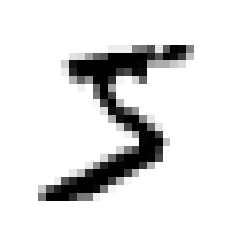

In [10]:
plt.imshow(some_digit_image,cmap = 'binary')
plt.axis('off')
plt.show()

In [11]:
y[0]

'5'

In [12]:
# 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환
y = y.astype(np.uint8)

In [13]:
# Mninst 데이터는 이미 훈련세트와 테스트 세트를 구분지어놈
X_train, X_test, y_train, y_test = X[:60000], X[60000:],y[:60000],y[60000:]

### 3.2 이진 분류기 훈련

문제를 단순화해서 하나의 숫자,,,5를 식별하는지 마는지 감지기 생성

In [14]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

##### 확률적 경사하강법인 SGDClassifier사용.

이 분류기는 매우 큰 데이터셋을 효율적으로 처리하는 장점 지님. 
이유는 SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문. 그래서 온라인 학습에 잘 맞음

In [15]:
from sklearn.linear_model import SGDClassifier

In [16]:
# SGDClassifier은 훈련하는데 무작위성을 사용합니다. 재현성을 위해 Seed값 지정해주어야!
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [17]:
# 숫자 5를 감지해보자!
sgd_clf.predict([some_digit])

array([ True])

분류기는 이 이미지가 5를 나타낸다고 <b>추측</b>했습니다. 이 경우엔 특별하게 정확히 맞춘 것 같습니다.

### 3.3 성능 측정

#####  3.3.1 교차 검증을 사용한 정확도 측정

직접 구현

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [19]:
skfolds = StratifiedKFold(n_splits = 3, random_state=42,shuffle=True)

In [20]:
for train_index ,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9559
0.9559
0.96565


StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행.<br>
매 반복에서 분류기 객체를 복제, 훈련 폴드로 훈련시키고 테스트 폴드로 예측,,<br>
그 다음 올바른 예측의 수를 세어 정확한 예측의 비율ㅇ르 출력

cross_val_score이용

In [21]:
from sklearn.model_selection import cross_val_score,cross_val_predict
cross_val_score(sgd_clf,X_train,y_train_5,cv = 3, scoring ='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 교차 검증 폴드에 대해 정확도가 95%이상.... <br>
모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보겠다

In [22]:
from sklearn.base import BaseEstimator

In [23]:
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1),dtype =bool)

##### 의미

이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줍니다. 
<br>
특히 <b> 불균형한 데이터 셋</b>를 다룰 때 더욱 그렇습니다

### 3.3.2 오차 행렬

In [25]:
from sklearn.model_selection import cross_val_predict

In [26]:
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3)

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_train_5,y_train_pred) # 입력 순서는 실제 , 예측

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행 : 실제 클래스, 열은 예측한 클래스<br>
1행 : "5 아님"을 의미( 음성 클래스).. 
2행 : "5 맞음"을 의미( 양성 클래스)..

In [29]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 3.3.3 정밀도와 재현율

In [30]:
from sklearn.metrics import precision_score,recall_score

In [31]:
precision_score(y_train_5,y_train_pred) # 정밀도(예측의 정확도)

0.8370879772350012

In [32]:
recall_score(y_train_5,y_train_pred) # 재현율

0.6511713705958311

In [33]:
# F1 score : 정밀도와 재현율을 조화평균 낸 식
from sklearn.metrics import f1_score

In [34]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846

### 3.3.4 정밀도/재현율 트레이드오프

사이킷런에서 임계값을 직접 정할 수는 없지만 예측에 사용한 점수는 확인할 수 있습니다. 분류기의 predict() 메서드 대신 deciscion_function()메서드를 호출하면 각 샘플의 점수를 얻을 수 있습니다. dl 점수를 기반으로 원하는 임곗값을 정해 예측을 만들 수 있습니다.

In [35]:
y_scores = sgd_clf.decision_function([some_digit])

In [36]:
y_scores

array([2164.22030239])

In [37]:
threshold = 0
y_some_digit_pred = (y_scores> threshold)

In [38]:
y_some_digit_pred

array([ True])

사실 predict()메서드도 decision_function()함수를 사용하여 0보다 큰 경우를 양성으로 예측

임계값을 높이면 재현율이 줄어든다는 것을 보여줍니다. 이미지가 실제로 숫자 5이고, 임계값이 0일때는 분류기가 이를 감지했지만, 임계값을 8000으로 높이면 이를 놓치게 됩니다.

In [39]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

##### 그렇다면 적절한 임계값을 어떻게 정할 수 있을까요?

이를 위해서는 먼저 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야합니다. 하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정해야합니다!<br>
method라는 파라미터에 decision_function입력

In [40]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv = 3,method = 'decision_function')

이 점수로 precision_recall_curve()함수를 사용하여 가능한 모든 임계값에 대해 정밀도와 재현율을 계산할 수 있습니다.

In [41]:
from sklearn.metrics import precision_recall_curve

In [42]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

In [43]:
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

In [44]:
precisions

array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
       1.        ])

In [45]:
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

이제 맷플롯립을 이용해 임계값의 함수로 정밀도와 재현율을 그릴 수 있습니다.

In [46]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],label = '정밀도')
    plt.plot(thresholds,recalls[:-1],label = '재현율')
    plt.legend(loc = 'center right', fontsize= 16)
    plt.xlabel('Threshold',fontsize = 16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])

In [47]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

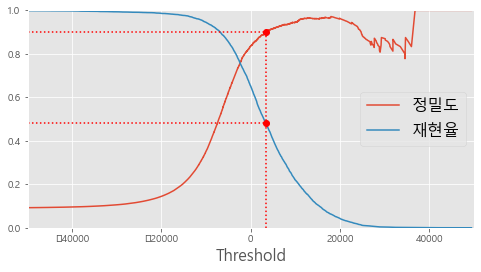

In [48]:
plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")
plt.show()

재현율과 정밀도의 그래프

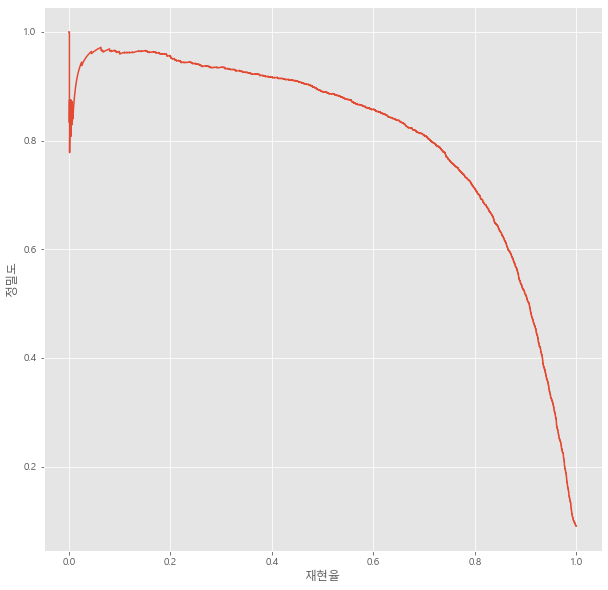

In [49]:
plt.figure(figsize = (10,10))
plt.plot(recalls,precisions)
plt.xlabel('재현율')
plt.ylabel('정밀도')
plt.show()

재현율이 90% 근처에서 정밀도가 급격하게 줄어들기 시작합니다.

이 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋습니다. 예를 들면 재현율이 60%정도인 지점입니다. 물론 이런 선택은 프로젝트에 따라 달라집니다

정밀도 90% 달성하는 것을 목표라고 가정. 최소한 정밀도가 90% 되는 가장 낮은 임계값을 찾자

np.argmax()는 최대값의 첫 번째 인덱스를 반환합니다! 여기서는 첫번째 True

In [50]:
threshold_90_precision

3370.0194991439557

(훈련 세트에 대한) 예측을 만들려면 분류기의 predict()메서드 대신 아래 코드 실행!

In [51]:
y_train_pred_90 = (y_scores>= threshold_90_precision)

이 예측에 대한 정밀도와 재현율을 확인!

In [52]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [53]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC곡선

In [54]:
from sklearn.metrics import roc_curve

In [55]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

In [56]:
def plot_roc_curve(fpr,tpr,label = None):
    plt.plot(fpr,tpr,linewidth = 2,label = label)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('거짓 양성 비율(FPR)')
    plt.ylabel('진짜 양성 비율(TPR,재현율)')

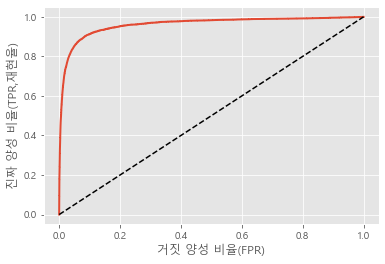

In [57]:
plot_roc_curve(fpr,tpr)
plt.show()

여기에서도 트레이드오프가 있습니다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓양성(FPR)이 늘어납니다. 점선은 완전한 랜덤 분류기의 ROC곡선을 뜻합니다.

곡선 아래 면적을 측정하면 분류기들을 비교할 수 있습니다. 완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤분류기는 0.5입니다. ROC의 AUC계산하는 함수는 아래입니다.

In [58]:
from sklearn.metrics import roc_auc_score

In [59]:
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

RandomForestClassifier과 비교

랜덤포레스트는 decision_function()메서드 대신 predict_proba()메서드 가지고 있음.<br>
사이킷런 분류기는 일반적으로 이 두 메서드 중 하나 또는 둘 모두를 가지고 있습니다.<br>
predict_proba() 메서드는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환합니다.

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [61]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv = 3,method = 'predict_proba')

In [62]:
y_probas_forest # (음성클래스, 양성클래스)

array([[0.1, 0.9],
       [1. , 0. ],
       [0.9, 0.1],
       ...,
       [0. , 1. ],
       [1. , 0. ],
       [1. , 0. ]])

양성 클래스 확률을 점수로 사용해보겠다!

In [63]:
y_score_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds = roc_curve(y_train_5,y_score_forest)

ROC곡선 그릴 때 비교를 위해 첫 번째 ROC곡선도 함께 그리겠습니다.

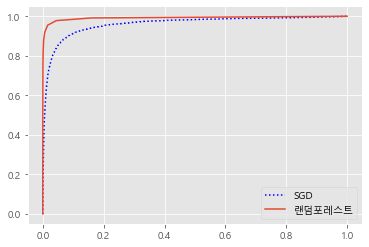

In [64]:
plt.plot(fpr,tpr,'b:',label = "SGD")
plt.plot(fpr_forest,tpr_forest,label = '랜덤포레스트')
plt.legend(loc = 'lower right')
plt.show()

In [65]:
roc_auc_score(y_train_5,y_score_forest)

0.9920527492698306

In [66]:
y_train_predict = cross_val_predict(forest_clf,X_train,y_train_5,cv = 3)

In [67]:
precision_score(y_train_5,y_train_predict)

0.986046511627907

In [68]:
recall_score(y_train_5,y_train_predict)

0.8212506917542889

## 다중 분류

2 이상의 클래스 분류하는 것!!

In [69]:
from sklearn.svm import SVC

In [ ]:
svm_clf = SVC()
svm_clf.fit(X_train,y_train) # 다중 분류이므로~ 전체!

In [ ]:
svm_clf.predict([some_digit])